In [1]:
#################################
# Goal of this code is to do all analysis in paper2 before plotting
# This code is used before Plot_all_figure_paper_updated.ipynb

# 1. KW amplitude
# 2. EAPE/EKE growth rate
# 3. Theoretical first and second mode phase speed
# 4. KW signal strength in wavenumber-frequency space
# 
# Mu-Ting Chien
# 2024.3.19
#####################################

In [2]:
import os
import sys
sys.path.append('/glade/work/muting/function/')
import KW_diagnostics as KW
import mjo_mean_state_diagnostics as MJO
import create_my_colormap as mycolor
RWB = mycolor.red_white_blue()

from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap # for plotting KW composite vertical structure

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Constant used for KW phase composite
pi  = np.pi
PI = '\u03C0'
bin_simple = np.arange(-pi,pi+1/4*pi,1/4*pi)

In [4]:
##########################################
# Main code below
##############################################

In [66]:
dir_out            = '/glade/work/muting/KW/'
CASENAME_LIST2     = list(['SST_AQP3_Qobs_27_-4K',\
                          'SST_AQP3_Qobs_27',\
                          'SST_AQP3_Qobs_27_4K'])
CASENAME_SHORT_LIST = list(['-4K','CTL','4K'])

icase          = 0 # 0-2
icase_ref      = icase
CASENAME       = CASENAME_LIST2[icase]+'_3h_20y'
figdir         = dir_out+'figure/Post_general/Test_number_of_years/'+CASENAME_SHORT_LIST[icase]+'_20yr/'
CASENAME_SHORT = CASENAME_SHORT_LIST[icase]+'_20y_3h_20y'
CASE_SHORT     = CASENAME_SHORT_LIST[icase]+'_10y'

if icase !=0:
    CASENAME_org = CASENAME
else:
    CASENAME_org = CASENAME+'_new2'
    
os.makedirs(figdir, exist_ok=True)
output_dir = dir_out+'output_data/'+CASENAME+'/'
os.makedirs(output_dir, exist_ok=True)
s2d = 86400

iyr_min = 2
iyr_max = 11
nyr = iyr_max-iyr_min+1
yr = np.arange(0,nyr)+1

latmax = 10

each_yr = 0 # whether plotting/saving output for each year or not, use 0 (no) or 1 (yes), choose each_yr = 0

In [67]:
# KW band for each simulation
if icase == 0: #-4K
    freq_min = 1/8
    freq_max = 1/2.5
    wnum_min = 1
    wnum_max = 15
    h_min    = 8
    h_max    = 50
elif icase == 1: #CTL
    freq_min = 1/7
    freq_max = 1/2.25
    wnum_min = 1
    wnum_max = 15
    h_min    = 12 
    h_max    = 90 
elif icase == 2: #+4K
    freq_min = 1/4
    freq_max = 1/2
    wnum_min = 1
    wnum_max = 15
    h_min    = 25 
    h_max    = 150

In [68]:
print(CASENAME)

SST_AQP3_Qobs_27_4K_3h_20y


In [69]:
#####################################################
# 0. Calculate zonal mean precip (for Supplementary figure)
##################################################
precip_saved_zm = 1
if precip_saved_zm == 0:
    
    # (0) Get nfile_skip
    nfile_skip = KW.find_nfile_skip(CASENAME, CASENAME_SHORT, iyr_min, iyr_max)

    # (1) Load precip
    precip, time, lat, lon = KW.load_2D_data_as_1variable(CASENAME_org, 'PRECL','PRECC', iyr_min, iyr_max, 90, \
                                                          1000*s2d, nfile_skip, 0)
    print('finish loading')

    # (1.5) Calculate time mean zonal mean
    pr_zm = np.mean(np.mean(precip,2),0)
    del precip
    
    # Save precip
    np.savez(output_dir+'precip_zm.npz', pr_zm = pr_zm, lat=lat)
else:
    data = np.load(output_dir+'precip_zm.npz')
    pr_zm = data['pr_zm']
    lat    = data['lat']

In [70]:
#################################
# 1. Obtain KW amplitude
#################################
precip_saved = 1

if precip_saved == 0:
    
    # (0) Get nfile_skip
    nfile_skip = KW.find_nfile_skip(CASENAME, CASENAME_SHORT, iyr_min, iyr_max)

    # (1) Load precip
    precip, time, lat, lon = KW.load_2D_data_as_1variable(CASENAME, 'PRECL','PRECC', iyr_min, iyr_max, latmax, \
                                                          1000*s2d, nfile_skip, 0)
    print('finish loading')

    # (1.5) Calculate non-projected precip anomaly, used for signal strength
    nt    = np.size(precip,0)
    pr_m2 = np.mean(precip,0)
    pr_m2 = np.tile(pr_m2,(nt,1,1))
    pr_ano = precip - pr_m2
    del pr_m2
    
    # Save precip
    np.savez(output_dir+'precip.npz', precip=precip, pr_ano=pr_ano, time=time, lat=lat, lon=lon)

else:
    
    data = np.load(output_dir+'precip.npz')
    precip = data['precip']
    pr_ano = data['pr_ano']
    time   = data['time']
    lon    = data['lon']
    lat    = data['lat']

In [71]:
precip_kw_saved = 1

if precip_kw_saved == 0:

    # (2) KW meridional projection / remove 10-day low-pass variability
    pr_kwproj = KW.KW_meridional_projection(precip, lat, tropics_or_midlat=0)
    pr_kwproj_ano = MJO.remove_10d_from_3hr_data(pr_kwproj)

    print('finish KW proj')

    # (4) KW-filtered precip
    KW_filtered_pr, time_pr = KW.KW_wavenumber_frequency_filter(pr_kwproj_ano, wnum_min, wnum_max,\
                    freq_min, freq_max, h_min, h_max)
    print('finish KW filtering')

    # Make sure time dimension is the same as phase_kw
    pr_kwproj_ano_short = pr_kwproj_ano[time_pr[0]:time_pr[-1]+1,:]

    # Calculate KW composite
    pr_KW_20y, phase_bin, phase_correct = KW.calculate_KW_phase(KW_filtered_pr, 'pr', 'mm/day', figdir)
    
    # Save kw precip
    np.savez(output_dir+'precip_kw.npz', pr_kwproj_ano_short=pr_kwproj_ano_short, KW_filtered_pr=KW_filtered_pr, \
         time_pr=time_pr, lon=lon, phase_bin=phase_bin, phase_correct=phase_correct, pr_kw = pr_KW_20y)
    
else:
    
    data = np.load(output_dir+'precip_kw.npz')
    pr_kwproj_ano_short = data['pr_kwproj_ano_short']
    KW_filtered_pr      = data['KW_filtered_pr']
    time_pr             = data['time_pr']
    lon                 = data['lon']
    phase_bin           = data['phase_bin']
    phase_correct       = data['phase_correct']


In [72]:
kw_amplitude_saved = 1

if kw_amplitude_saved == 0:
    
    # Composite by KW phase
    pr_KW, bin_center = KW.composite_by_kw_phase(pr_kwproj_ano_short[:,:], phase_correct[:,:], time_pr[:])
    KW_amplitude = ( np.abs( np.min(pr_KW) )+ np.max(pr_KW) )/2 
    np.savez(output_dir+'kw_amplitude_gr_Cp.npz', KW_amplitude=KW_amplitude)
    
else:

    # Load KW composite field
    data = np.load(output_dir+'kw_amplitude_gr_Cp.npz')  
    KW_amplitude = data['KW_amplitude']
    

In [74]:
###################################
# 2. Obtain EAPE growth rate 
###############################

QT_saved = 1

if QT_saved == 0:
    
    # (0) Get nfile_skip
    nfile_skip = KW.find_nfile_skip(CASENAME, CASENAME_SHORT, iyr_min, iyr_max)
    
    # (1) Load T and Q & Calculate anomaly
    vname = list(['T'])
    Tproj, Tm, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip)
    Ta = MJO.remove_10d_from_3hr_data(Tproj) #(time, plev, lon)
    
    vname = list(['DTCOND'])
    Qproj, Qm, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip)
    Qa = MJO.remove_10d_from_3hr_data(Qproj) #(time, plev, lon)
    
    
    # Test: check mean state T makes sense
    plt.subplot(1,2,1)
    plt.title('Tm')
    plt.plot(Tm, plev)
    plt.gca().invert_yaxis()
    plt.subplot(1,2,2)
    plt.title('Qm')
    plt.plot(Qm*s2d, plev)
    plt.gca().invert_yaxis()
    plt.show()
    
    # Save data
    np.savez(output_dir+'QT.npz', Tproj=Tproj, Qproj=Qproj, Tm=Tm, Qm=Qm, Qa=Qa, Ta=Ta, \
             time=time, plev=plev, lon=lon)
    
else:
    data = np.load(output_dir+'QT.npz')
    Tproj = data['Tproj'] #(time, plev, lon), raw T data projected onto KW meridional structure
    Qproj = data['Qproj'] #(time, plev, lon), raw Q data projected onto KW meridional structure
    Tm    = data['Tm'] #(plev), mean state temperature profile
    Qm    = data['Qm'] #(plev), mean state Q profile
    Ta    = data['Ta'] #(time, plev, lon), projected T, without 10-day low pass filtered variability
    Qa    = data['Qa'] #(time, plev, lon), projected Q, without 10-day low pass filtered variability
    time  = data['time']
    plev  = data['plev']
    lon   = data['lon']

0 39
finish vertical integration
Theta before adjustment: 0.39269908169872414
Theta final: 0.39269908169872414


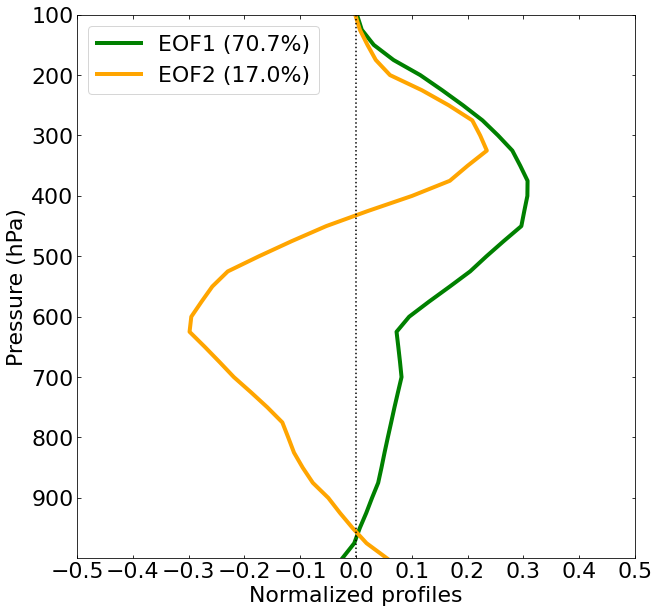

In [75]:
# 2.1 Calculate EOF
saved_eof = 0

# Test: use only 125-900hPa to calculate vertical mode decomposition
ilevmin = np.argwhere(plev==25).squeeze() 
ilevmax = np.argwhere(plev==1000).squeeze()
print(ilevmin, ilevmax)


if saved_eof == 0:
    
    EOF1, EOF2, PC1, PC2 = KW.calculate_plot_eof(Qa[:,ilevmin:ilevmax+1,:], plev[ilevmin:ilevmax+1], 0, figdir)

    # Rotation of EOF
    R_EOF1_raw, R_EOF2_raw, th = KW.rotate_eof(EOF1, EOF2, plev[ilevmin:ilevmax+1], icase_ref, figdir)

    plev_small = plev[ilevmin:ilevmax+1]
    nlev_small = np.size(plev_small)

    # Apply 10 passes of 1-2-1 filter for smoothing of EOF
    R_EOF1_smooth = KW.smoothing_121(R_EOF1_raw)
    R_EOF2_smooth = KW.smoothing_121(R_EOF2_raw)

    np.savez(output_dir+'EOF.npz', R_EOF1_raw=R_EOF1_raw, R_EOF2_raw=R_EOF2_raw,\
        R_EOF1_smooth=R_EOF1_smooth, R_EOF2_smooth=R_EOF2_smooth, plev_small=plev_small)        
    
else:

    data = np.load(output_dir+'EOF.npz')
    R_EOF1_raw = data['R_EOF1_raw']
    R_EOF2_raw = data['R_EOF2_raw']
    R_EOF1_smooth = data['R_EOF1_smooth']
    R_EOF2_smooth = data['R_EOF2_smooth']
    plev_small = data['plev_small']
        

In [78]:
# 2.2 Calculate vertical modes of omega and U from EOF of Q (Step1)
# also preparing for phase speed calculation

saved_SpN2 = 1

if saved_SpN2 == 0:
    
    # (0) Get nfile_skip
    nfile_skip = KW.find_nfile_skip(CASENAME, CASENAME_SHORT, iyr_min, iyr_max)
    
    # Load z:
    vname = list(['Z3'])
    Zproj, Zm, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip)

    # Load W:
    vname = list(['OMEGA'])
    Wproj, Wm, time, plev, lon = KW.load_3D_data_as_1variable(CASENAME, CASENAME_SHORT, vname, iyr_min, iyr_max, latmax, nfile_skip)

    # Calculate Sp
    Sp, N2, Hs, plev_N2 = KW.calculate_Sp_N2_Hs(Tm, Zm, plev)

    # Test Sp &N^2 is correct
    plt.subplot(1,2,1)
    plt.plot(Sp, plev_new, 'b')
    plt.gca().invert_yaxis()
    plt.title('Sp')
    plt.subplot(1,2,2)
    plt.plot(N2, plev_new, 'r')
    plt.gca().invert_yaxis()
    plt.title('N^2')
    plt.show()
    
    # Save data
    np.savez(output_dir+'W_Z.npz', Wproj=Wproj, Zproj=Zproj, Wm=Wm, Zm=Zm, time=time, plev=plev, lon=lon)
    np.savez(output_dir+'Sp_N2.npz',Sp=Sp, N2=N2, plev_N2=plev_N2)

else:
    data = np.load(output_dir+'W_Z.npz')
    Wproj = data['Wproj']
    Zproj = data['Zproj']
    Wm    = data['Wm']
    Zm    = data['Zm']
    time  = data['time']
    plev  = data['plev']
    lon   = data['lon']
    
    data = np.load(output_dir+'Sp_N2.npz')
    Sp   = data['Sp']
    N2   = data['N2']
    plev_N2 = data['plev_N2']

In [79]:
# (continued 2.2) Calculate vertical modes of omega and U from EOF of Q (Step2)

save_eofwu = 0

if save_eofwu == 0:
    
    # Load Sp
    data = np.load(output_dir+'Sp_N2.npz')
    plev_Sp = data['plev_N2']
    ilev_minSp = np.argwhere(plev_Sp==50).squeeze()
    Sp = data['Sp'][ilev_minSp:]
    plev_Sp_new = plev_Sp[ilev_minSp:]

    # Find vertical mode of omega and U
    EOF1_W, EOF2_W, EOF1_U, EOF2_U = KW.Q_vert_mode_to_WU( R_EOF1_raw[1:-1], R_EOF2_raw[1:-1], Sp )

    # Save output
    np.savez(output_dir+'EOF_WU.npz', EOF1_W=EOF1_W[1:-1], EOF1_U=EOF1_U, EOF2_W=EOF2_W[1:-1], EOF2_U=EOF2_U, plev_eofu = plev_Sp_new[1:-1])
else:
    
    data = np.load(output_dir+'EOF_WU.npz')
    EOF1_U = data['EOF1_U']
    EOF2_U = data['EOF2_U']
    plev_eofu = data['plev_eofu']


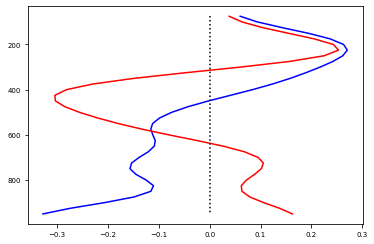

In [80]:
plev_eofu = plev_Sp_new[1:-1]
zero = np.zeros([np.size(plev_eofu)])
plt.plot(EOF1_U, plev_eofu, 'b')
plt.plot(EOF2_U, plev_eofu, 'r')
plt.plot(zero, plev_eofu, 'k:')
plt.gca().invert_yaxis()
plt.show()

In [82]:
# 2.3 Calculate KW composite vertical structure of Q and T

QT_kw_saved = 1

# Make sure Ta and Qa have the same size as kw-filtered precip
Ta_trim = Ta[time_pr[0]:time_pr[-1]+1, :, :]
Qa_trim = Qa[time_pr[0]:time_pr[-1]+1, :, :]

if QT_kw_saved == 0:
    
    T_KW, phase = KW.composite_by_kw_phase(Ta_trim[:,:,:], phase_correct[:,:], time_pr[:]) #(phase, plev)
    Q_KW, phase = KW.composite_by_kw_phase(Qa_trim[:,:,:], phase_correct[:,:], time_pr[:])
    np.savez(output_dir+'QT_kw.npz', Q_KW=Q_KW, T_KW=T_KW, plev=plev, phase=phase)
    
else:
    
    data = np.load(output_dir+'QT_kw.npz')
    Q_KW = data['Q_KW'][:,:]
    T_KW = data['T_KW'][:,:]     
    plev  = data['plev']
    phase = data['phase']
    nphase = np.size(phase)
    

In [83]:
###################################
# Calculate EKE growth rate
####################################
FU_saved = 1
if FU_saved == 0:
    
    # (0) Get nfile_skip
    nfile_skip = KW.find_nfile_skip(CASENAME, CASENAME_SHORT, iyr_min, iyr_max)
    
    # (1) Load U and F
    ist = 0
    for iyr in range(iyr_min, iyr_max+1):
        yr_str = str(iyr+1)
        file_in = dir_out+'output_data/'+CASENAME+'/F/F_eddy_momentum_forcing_'+yr_str+'.nc'
        data = Dataset(file_in, "r", format="NETCDF4")
        if iyr == iyr_min:
            plev_FU = data.variables['plev'][:]
            lon  = data.variables['lon'][:]
            
            nlev = np.size(plev)
            nlon = np.size(lon)
            nmon = 12
            nt_s = 31
            nt = nmon*8*nt_s*(iyr_max-iyr_min+1)-nfile_skip*nt_s
            Fa = np.empty([nt, nlev, nlon])
            ua = np.empty([nt, nlev, nlon])
               
        tmp1 = data.variables['Fa'][:]
        tmp2 = data.variables['ua'][:]
        nt_small = np.size(tmp1,0)
        Fa[ist:ist+nt_small,:,:] = tmp1[:,:,:]
        ua[ist:ist+nt_small,:,:] = tmp2[:,:,:]
        
        ist = ist + nt_small

    time  = np.arange(0,ist)
        
    # Save data
    np.savez(output_dir+'FU.npz', Fa=Fa, ua=ua, time=time, plev_FU=plev_FU, lon=lon)
    
else:
    data = np.load(output_dir+'FU.npz')
    Fa    = data['Fa'] #(time, plev, lon), projected T, without 10-day low pass filtered variability
    ua    = data['ua'] #(time, plev, lon), projected T, without 10-day low pass filtered variability
    time  = data['time']
    plev_FU  = data['plev']
    lon   = data['lon']

In [84]:
FU_kw_saved = 1

# Load Fa, Ua

# Make sure Ta and Qa have the same size as kw-filtered precip
Fa_trim = Fa[time_pr[0]:time_pr[-1]+1, :, :]
ua_trim = ua[time_pr[0]:time_pr[-1]+1, :, :]

if FU_kw_saved == 0:

    U_KW, phase = KW.composite_by_kw_phase(ua_trim[:,:,:], phase_correct[:,:], time_pr) #(phase, plev)
    F_KW, phase = KW.composite_by_kw_phase(Fa_trim[:,:,:], phase_correct[:,:], time_pr)
    nphase = np.size(phase)
    nlev = np.size(F_KW,1)
    
    # save output
    np.savez(output_dir+'FU_kw.npz', F_KW=F_KW, U_KW=U_KW, plev_FU=plev_FU, phase=phase)
    
else:
    data = np.load(output_dir+'FU_kw.npz')
    F_KW = data['F_KW']
    U_KW = data['U_KW']
    plev_FU  = data['plev_FU']
    phase = data['phase']
    nphase = np.size(phase)

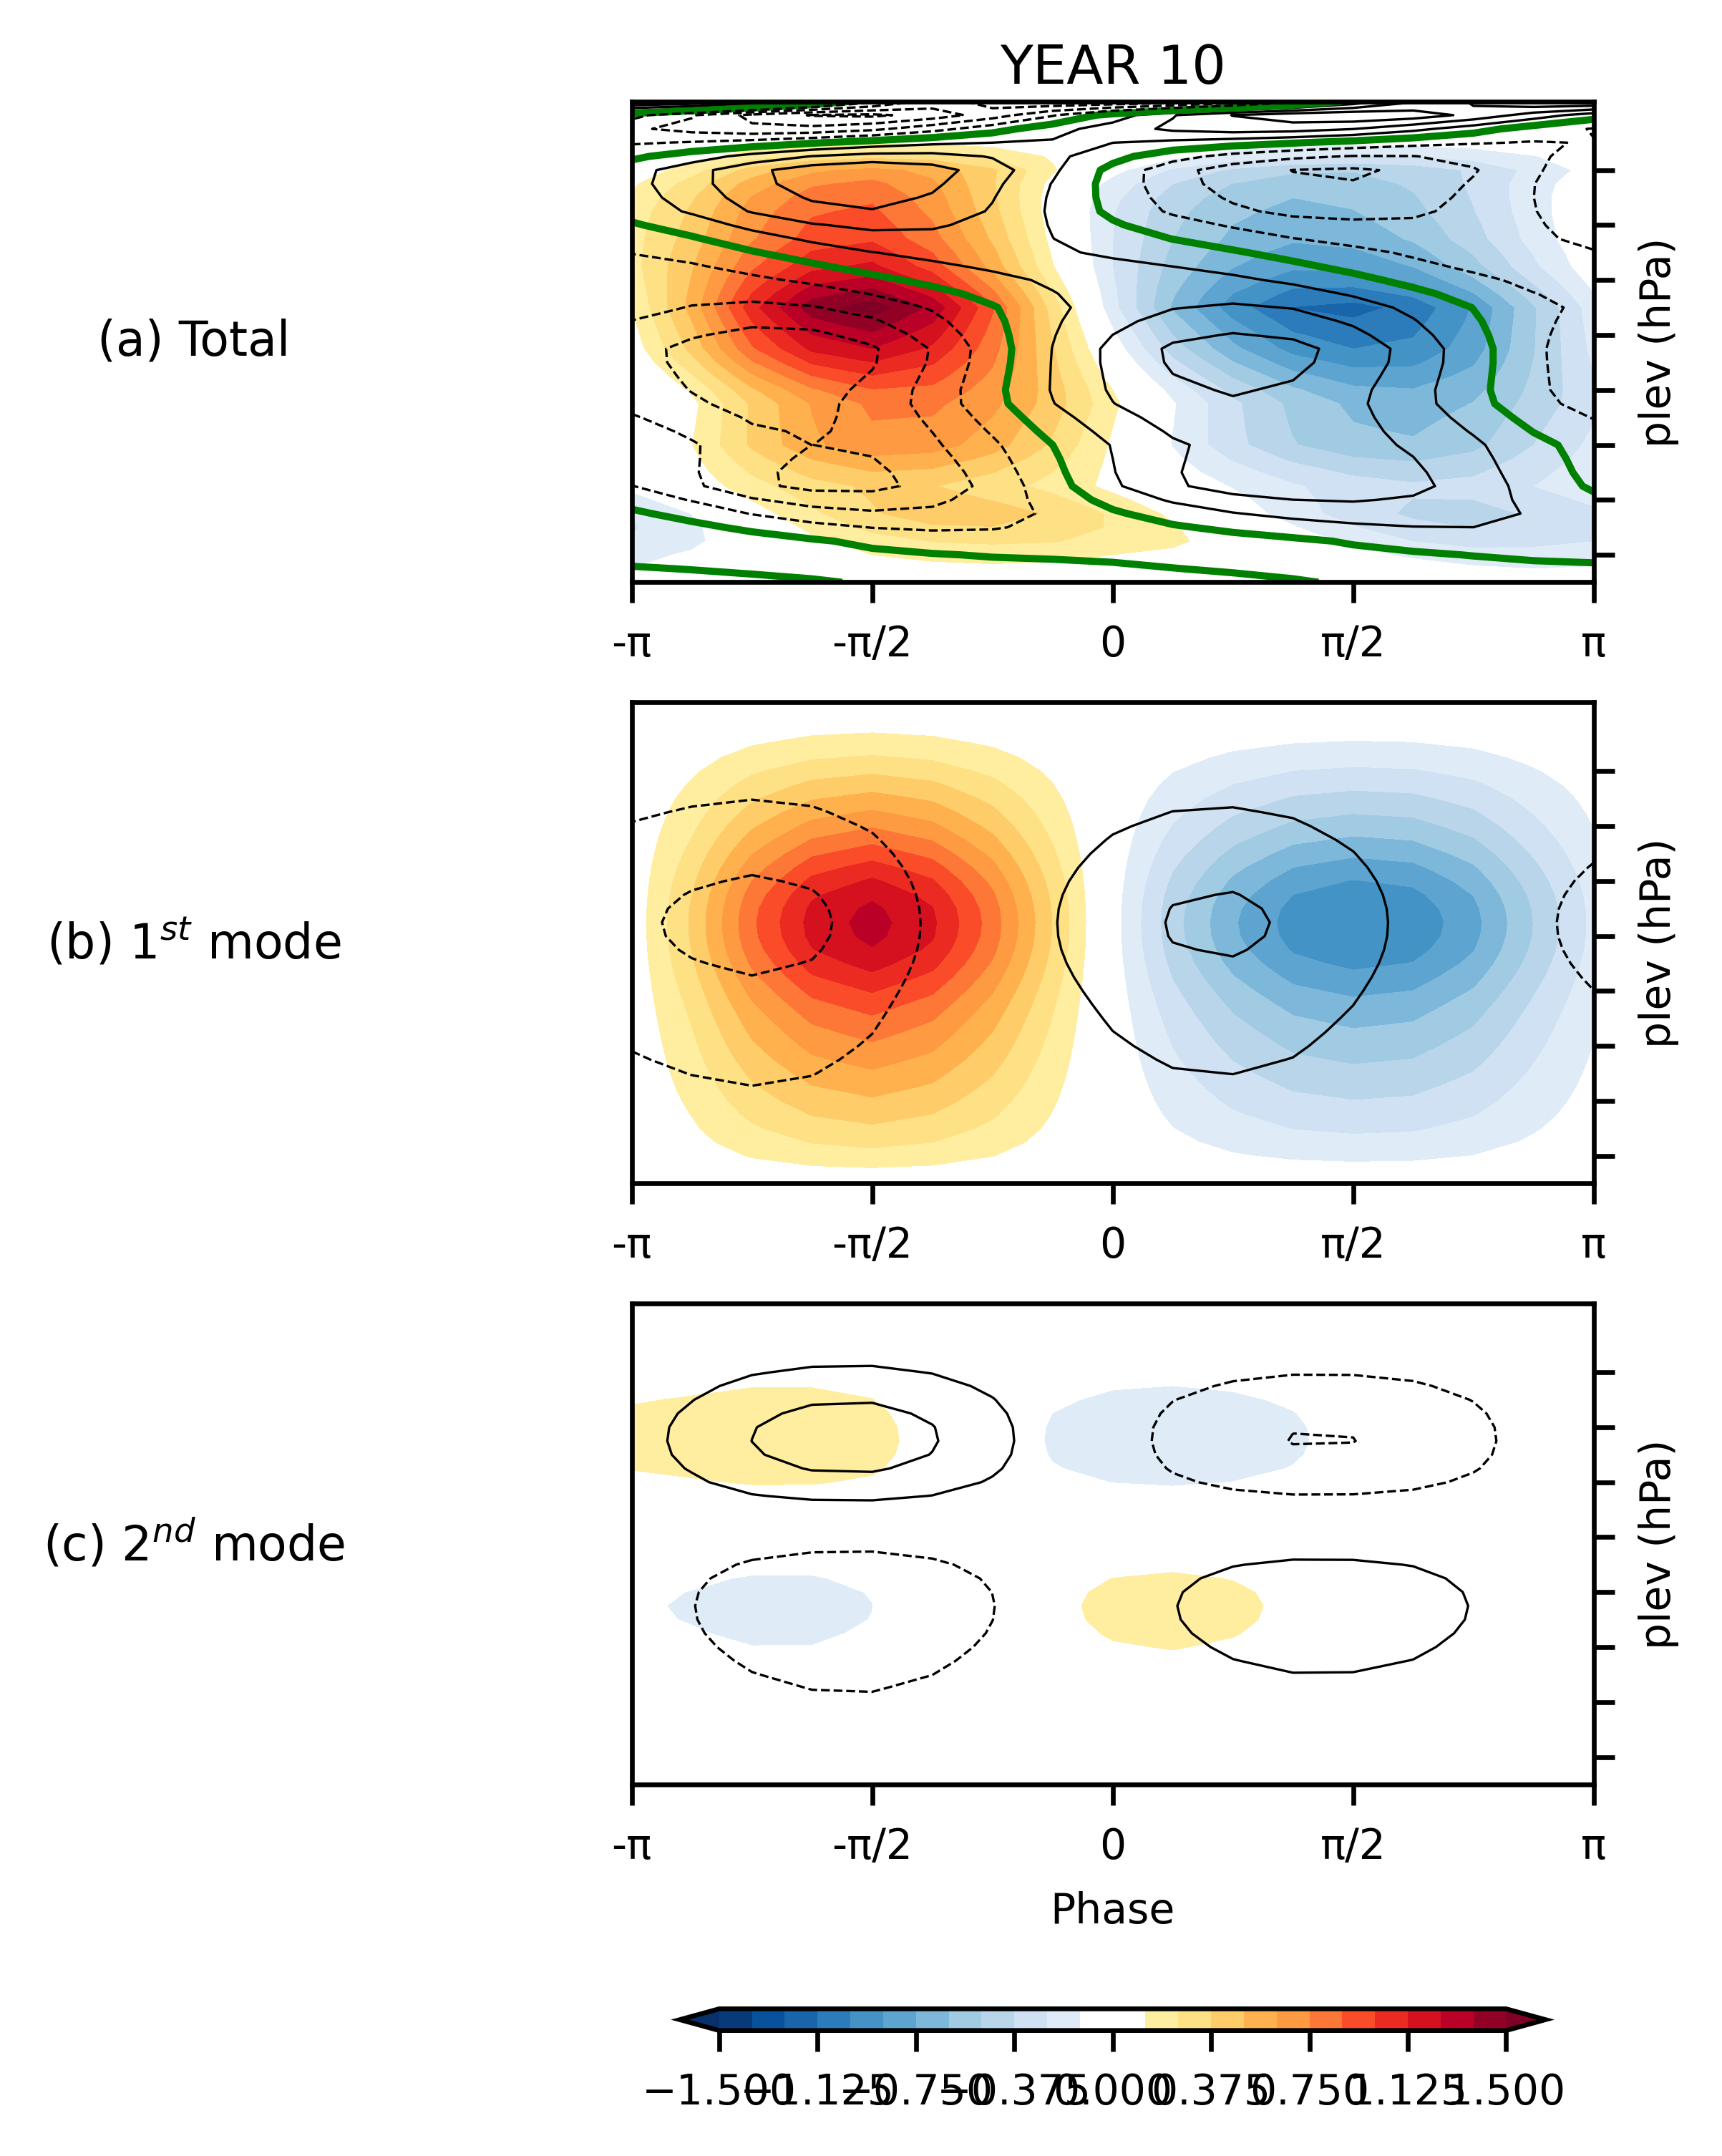

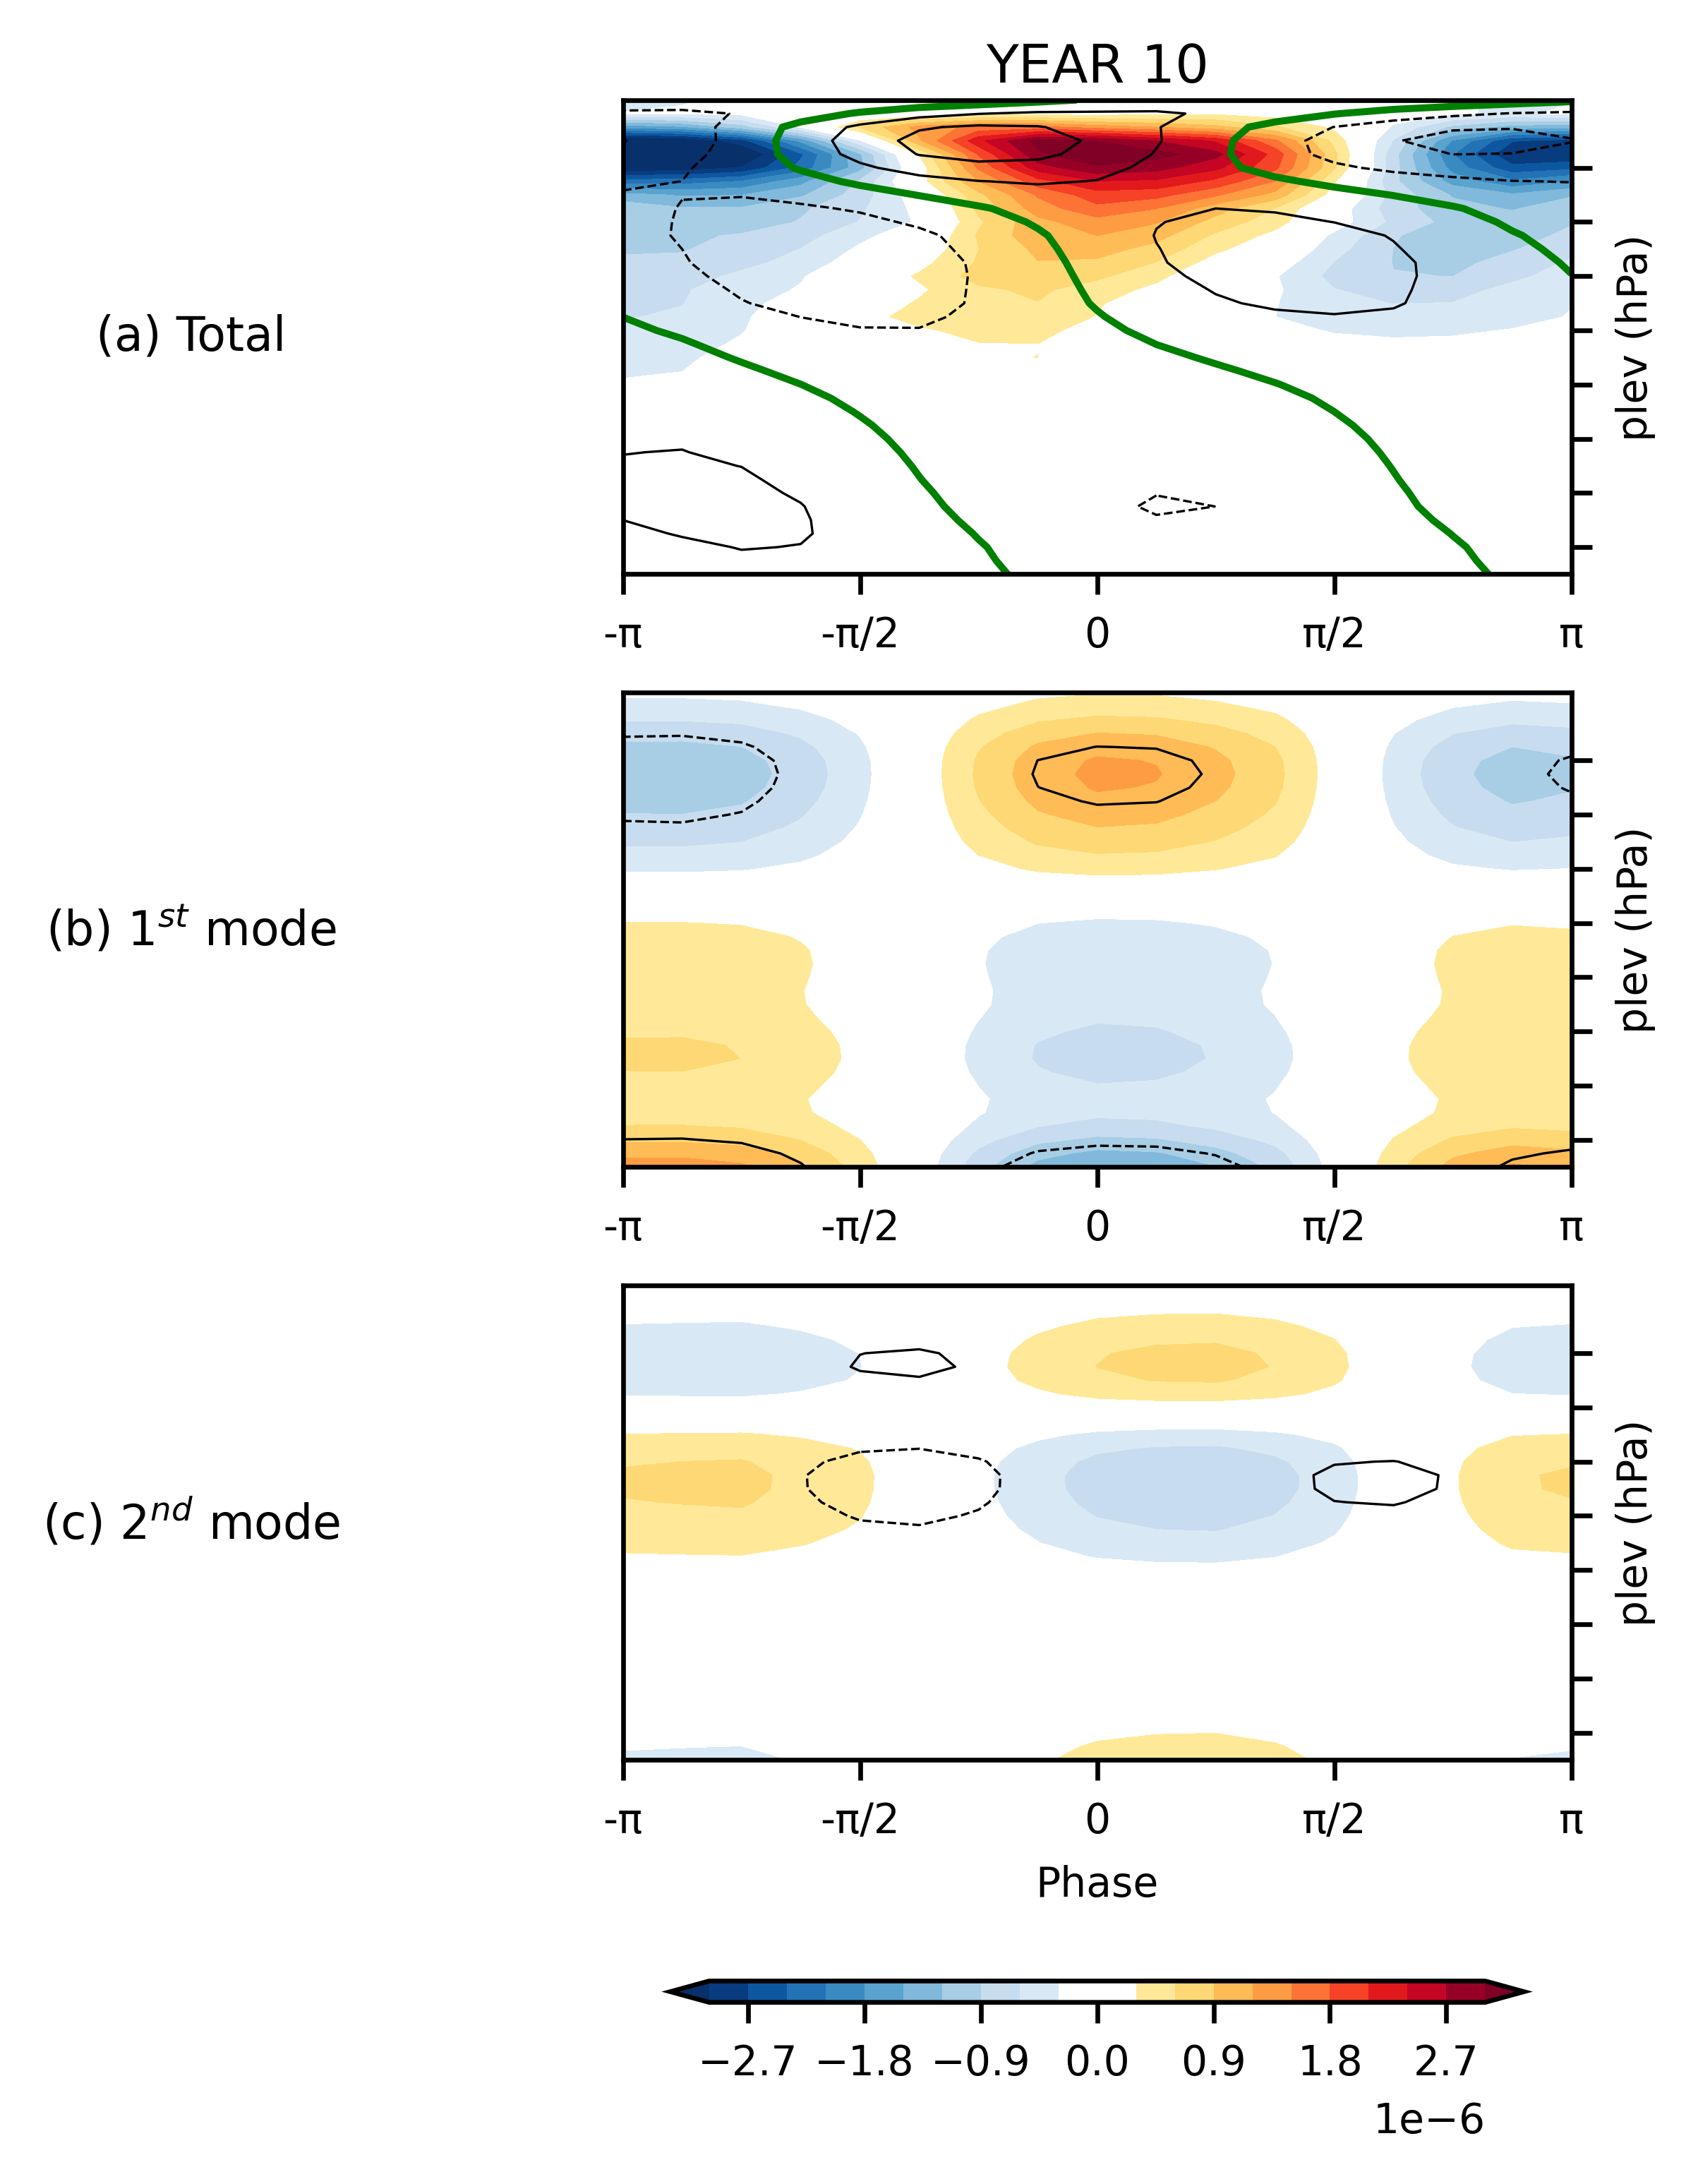

In [85]:
# Plot vertical mode decomposition of KW

font = 7

for iyr in range(nyr-1,nyr):
    
    ######################
    # Calculate vertical mode decomp
    ilevmin_Q = np.argwhere(plev==75).squeeze() 
    ilevmax_Q = np.argwhere(plev==950).squeeze()
    T1_KW, T2_KW = KW.vertical_mode_decomposition(T_KW[:,ilevmin_Q:ilevmax_Q+1], R_EOF1_smooth[2:-2], R_EOF2_smooth[2:-2])
    Q1_KW, Q2_KW = KW.vertical_mode_decomposition(Q_KW[:,ilevmin_Q:ilevmax_Q+1], R_EOF1_smooth[2:-2], R_EOF2_smooth[2:-2])        
    
    ilevmin_F = np.argwhere(plev_FU==75).squeeze() 
    ilevmax_F = np.argwhere(plev_FU==950).squeeze()
    F1_KW, F2_KW = KW.vertical_mode_decomposition(F_KW[:,ilevmin_F:ilevmax_F+1], EOF1_U, EOF2_U)
    U1_KW, U2_KW = KW.vertical_mode_decomposition(U_KW[:,ilevmin_F:ilevmax_F+1], EOF1_U, EOF2_U)
    
    plev_FU = plev_FU[ilevmin_F:ilevmax_F+1]
    
    # PLotting
    plot_fignum = 3 
    clev_0 = 0
    txt_xloc = -6
    txt_yloc = (np.min(plev_FU)+np.max(plev_FU))/2
    row_name = list(['(a) Total','(b) 1$^{st}$ mode','(c) 2$^{nd}$ mode'])

    for iplt in range(0,2): # if iplt == 0, plot QT, if iplt == 1, plot uF

        xx, yy = np.meshgrid(phase, plev_FU)
        # Set contour and contourf levels
        if iplt == 0: # plot Q,T
            clev_n = np.arange(-6,0,0.5)*0.5/4
            clev_p = np.arange(0.5,6.5,0.5)*0.5/4
            clev   = np.arange(-6,6.5,0.5)/4#*0.5
            if each_yr == 1:
                VAR_cf  = Q_KW_allyr[iyr,:,ilevmin_Q:ilevmax_Q+1]*s2d
                VAR_cn  = T_KW_allyr[iyr,:,ilevmin_Q:ilevmax_Q+1]
            else:
                VAR_cf  = Q_KW[:,ilevmin_Q:ilevmax_Q+1]*s2d
                VAR_cn  = T_KW[:,ilevmin_Q:ilevmax_Q+1]                
            VAR1_cf = Q1_KW*s2d
            VAR2_cf = Q2_KW*s2d
            VAR1_cn = T1_KW
            VAR2_cn = T2_KW
        elif iplt == 1: # plot F, U
            clev_n = np.arange(-4.5,0,0.5)
            clev_p = np.arange(0.5,5,0.5)
            clev = np.arange(-3,3.3,0.3)*10**(-6)
            VAR_cf  = F_KW[:,ilevmin_F:ilevmax_F+1]
            VAR_cn  = U_KW[:,ilevmin_F:ilevmax_F+1]
            VAR1_cf = F1_KW
            VAR2_cf = F2_KW
            VAR1_cn = U1_KW
            VAR2_cn = U2_KW

        fig,axes = plt.subplots(plot_fignum,1,figsize=(3.2, 5.5),dpi=600)
        plt.subplots_adjust(left=0.2,right=0.9,top=0.95,bottom=0,hspace=0.25,wspace=0.1)
        plt.rcParams.update({'font.size': font})

        plt.subplot(plot_fignum,1,1)
        ax = plt.gca()
        yr_str = "%02d" %(iyr+1)
        plt.title('YEAR '+yr_str, pad=3, loc='center',fontsize=9)

        cf  = plt.contourf(xx, yy, VAR_cf.T, levels=clev, cmap=get_cmap(RWB), extend='both' )
        cn_p = plt.contour(xx, yy, VAR_cn.T, levels=clev_p, colors='k', linewidths=0.4)
        cn_0 = plt.contour(xx, yy, VAR_cn.T, levels=clev_0, colors='g', linewidths=1.2)
        cn_n = plt.contour(xx, yy, VAR_cn.T, levels=clev_n, colors='k', linestyles='dashed',linewidths=0.4)
        plt.ylim([np.min(plev_FU), np.max(plev_FU)])
        plt.yticks(np.arange(200,1000,100))
        plt.gca().invert_yaxis()
        plt.xticks(np.arange(-pi,pi+pi/2,pi/2),('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
        plt.tick_params(bottom=True,top=False,left=False,right=True)
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)
        plt.text(txt_xloc,txt_yloc,row_name[0],fontsize=8,horizontalalignment='center',verticalalignment='center') 
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('plev (hPa)',fontsize=font)

        plt.subplot(plot_fignum,1,2)
        ax = plt.gca()
        cf  = plt.contourf(xx, yy, VAR1_cf.T, levels=clev, cmap=get_cmap(RWB), extend='both' )
        cn_p = plt.contour(xx, yy, VAR1_cn.T, levels=clev_p, colors='k', linewidths=0.4)
        cn_n = plt.contour(xx, yy, VAR1_cn.T, levels=clev_n, colors='k', linestyles='dashed',linewidths=0.4)
        plt.ylim([np.min(plev_FU), np.max(plev_FU)])
        plt.yticks(np.arange(200,1000,100))
        plt.gca().invert_yaxis()
        plt.xticks(np.arange(-pi,pi+pi/2,pi/2),('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
        plt.tick_params(bottom=True,top=False,left=False,right=True)
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)
        plt.text(txt_xloc,txt_yloc,row_name[1],fontsize=8,horizontalalignment='center',verticalalignment='center') 
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('plev (hPa)',fontsize=font)

        plt.subplot(plot_fignum,1,3)
        ax = plt.gca()
        cf  = plt.contourf(xx, yy, VAR2_cf.T, levels=clev, cmap=get_cmap(RWB), extend='both' )
        cn_p = plt.contour(xx, yy, VAR2_cn.T, levels=clev_p, colors='k', linewidths=0.4)
        cn_n = plt.contour(xx, yy, VAR2_cn.T, levels=clev_n, colors='k', linestyles='dashed',linewidths=0.4) 
        plt.ylim([np.min(plev_FU), np.max(plev_FU)])
        plt.yticks(np.arange(200,1000,100))
        plt.gca().invert_yaxis()
        plt.xticks(np.arange(-pi,pi+pi/2,pi/2),('-'+PI,'-'+PI+'/2','0',PI+'/2',PI),fontsize=font)
        plt.tick_params(bottom=True,top=False,left=False,right=True)
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)
        plt.text(txt_xloc,txt_yloc,row_name[2],fontsize=8,horizontalalignment='center',verticalalignment='center') 
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('plev (hPa)',fontsize=font)
        plt.xlabel('Phase',fontsize=font)

        cb = plt.colorbar(cf,ax=axes,orientation = 'horizontal', shrink=.9, aspect=40,pad=0.1) 
        if iplt == 0:
            plt.savefig(figdir+'Q_T_KW_1st_2nd.png',dpi=600)
        elif iplt == 1:
            plt.savefig(figdir+'F_U_KW_1st_2nd.png',dpi=600)
        plt.show()
        plt.close()

In [86]:
# Calculate EAPE growth rate
saved_EAPEGR = 0

if saved_EAPEGR == 0:
        
    PC1_Q_kwcomp = np.inner(Q_KW[:,ilevmin_Q:ilevmax_Q+1], R_EOF1_smooth[2:-2]) #(nphase)
    PC2_Q_kwcomp = np.inner(Q_KW[:,ilevmin_Q:ilevmax_Q+1], R_EOF2_smooth[2:-2])
    PC1_T_kwcomp = np.inner(T_KW[:,ilevmin_Q:ilevmax_Q+1], R_EOF1_smooth[2:-2])
    PC2_T_kwcomp = np.inner(T_KW[:,ilevmin_Q:ilevmax_Q+1], R_EOF2_smooth[2:-2])        

    EAPEGR1 = 2*np.mean(PC1_Q_kwcomp*PC1_T_kwcomp)/np.mean(PC1_T_kwcomp**2)
    EAPEGR2 = 2*np.mean(PC2_Q_kwcomp*PC2_T_kwcomp)/np.mean(PC2_T_kwcomp**2)       
    np.savez(output_dir+'EAPE_gr.npz', EAPEGR1=EAPEGR1, EAPEGR2=EAPEGR2)
    
else:
    data = np.load(output_dir+'kw_amplitude_gr_Cp.npz') 
    EAPEGR1 = data['EAPEGR1']
    EAPEGR2 = data['EAPEGR2']

In [88]:
print('EAPEGR1:',EAPEGR1*s2d)
print('EAPEGR2:',EAPEGR2*s2d)

EAPEGR1: -10.469687782148286
EAPEGR2: 2.0041283539897834


In [89]:
# Calculate EKE growth rate
saved_EKEGR = 0

if saved_EKEGR == 0:

    PC1_F_kwcomp= np.inner(F_KW[:,ilevmin_F:ilevmax_F+1], EOF1_U[:]) #(nphase)
    PC2_F_kwcomp= np.inner(F_KW[:,ilevmin_F:ilevmax_F+1], EOF2_U[:]) #(nphase)
    PC1_U_kwcomp= np.inner(U_KW[:,ilevmin_F:ilevmax_F+1], EOF1_U[:]) #(nphase)
    PC2_U_kwcomp= np.inner(U_KW[:,ilevmin_F:ilevmax_F+1], EOF2_U[:]) #(nphase)

    EKEGR1 = 2*np.mean(PC1_F_kwcomp*PC1_U_kwcomp)/np.mean(PC1_U_kwcomp**2)
    EKEGR2 = 2*np.mean(PC2_F_kwcomp*PC2_U_kwcomp)/np.mean(PC2_U_kwcomp**2)
    
    # Save output
    np.savez(output_dir+'EKE_gr.npz', EKEGR1=EKEGR1, EKEGR2=EKEGR2)
    
else:
    
    data = np.load(output_dir+'EKE_gr.npz')
    EKEGR1 = data['EKEGR1']
    EKEGR2 = data['EKEGR2']

print('EKEGR1:',EKEGR1*s2d)
print('EKEGR2:',EKEGR2*s2d)

EKEGR1: 0.33506509201805573
EKEGR2: -0.041337729876029336


In [90]:
#######################
# 3. Calculate Cp1, Cp2
##########################

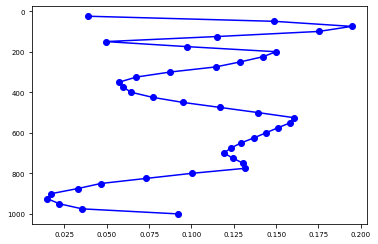

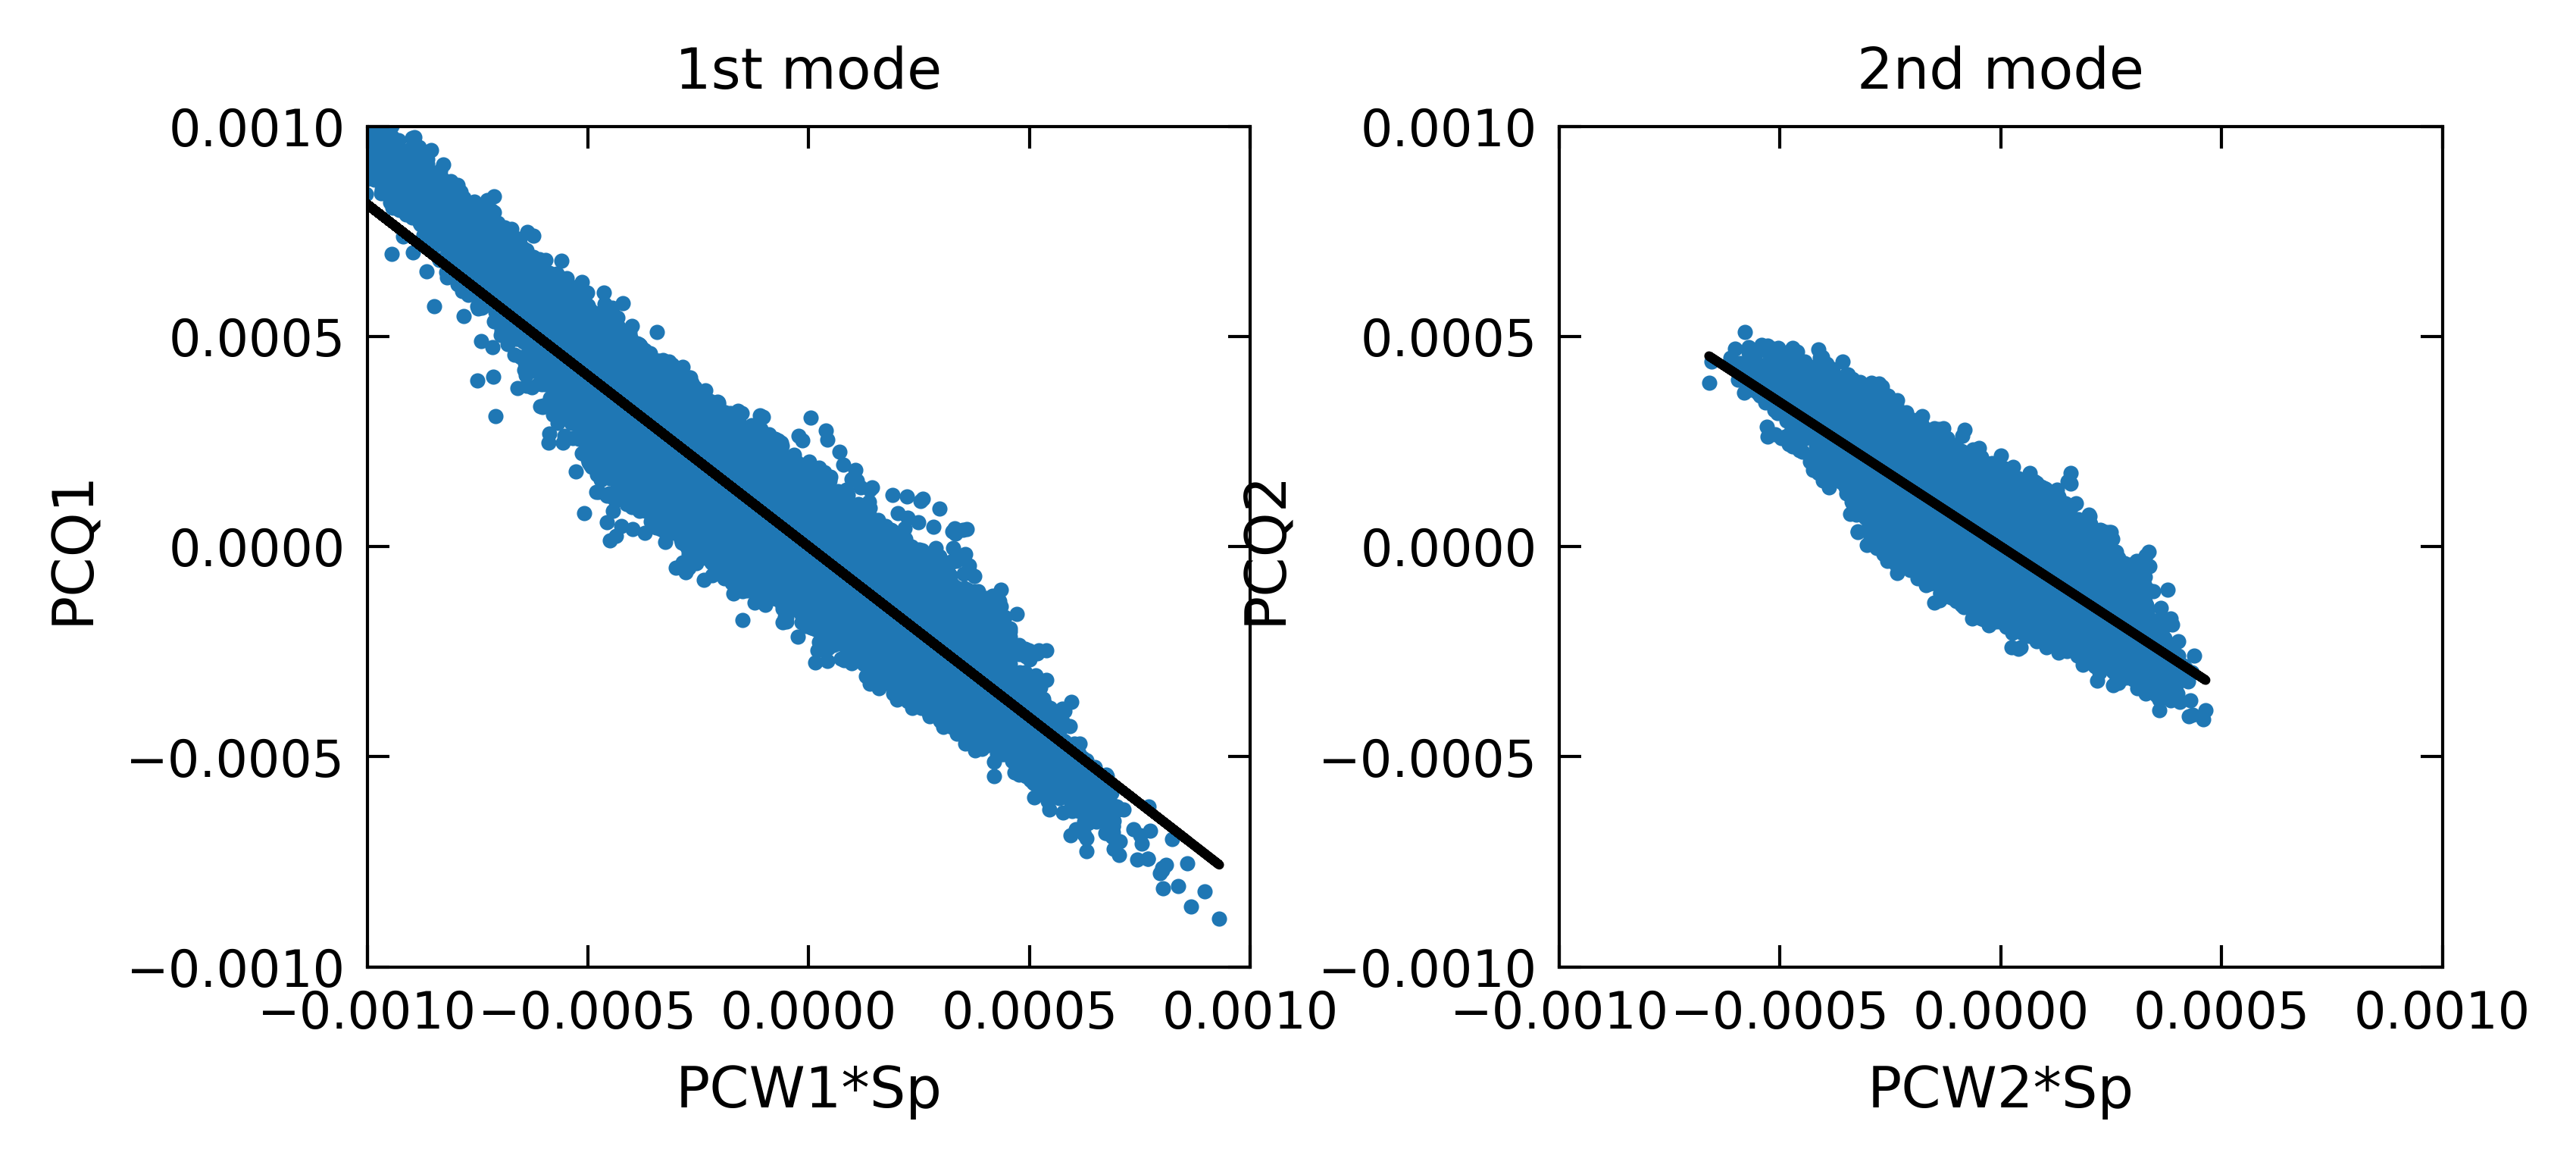

In [92]:
# Calculate Cp1, Cp2
saved_Cp12 = 0
if saved_Cp12 == 0:

    PCWS1_raw, PCWS2_raw = KW.calculate_PCWS(Tproj_trim[:,:,:], Zproj_trim[:,:,:],\
                            Wproj_trim[:,:,:], R_EOF1_smooth[2:-2], R_EOF2_smooth[2:-2], plev[ilevmin_Q:ilevmax_Q+1])

    ilev_N2_min = np.argwhere(plev_N2 == 75).squeeze()
    ilev_N2_max = np.argwhere(plev_N2 == 950).squeeze()
        
        
    data = np.load(output_dir+'W_Z.npz') 
    plev = data['plev']
        
    # Find pressure level of the lower boundary of TTL 
    ilev_STbot = np.argwhere(plev==75).squeeze()
    ilev_300   = np.argwhere(plev==300).squeeze()
    ilev_TTL, plev_TTL = KW.find_plev_tropopause(T_KW[:,:], plev, ilev_STbot, ilev_300)

        
    Cp1, Cp2, He1, He2, Lz1, Lz2, N2_1, N2_2, a1, a2 = KW.calculate_Cp1_Cp2(Tm, Zm, ilev_TTL, N2[ilev_N2_min:ilev_N2_max+1], R_EOF1_smooth[2:-2], R_EOF2_smooth[2:-2], \
                        PCQ1_raw[:,:], PCQ2_raw[:,:], PCWS1_raw[:,:], PCWS2_raw[:,:], time_pr[:], phase_correct[:,:])
        
    np.savez(output_dir+'Cp.npz', Cp1=Cp1, Cp2=Cp2, He1=He1, He2=He2, Lz1=Lz1, Lz2=Lz2, N2_1=N2_1, N2_2=N2_2, a1=a1, a2=a2)
    
else:
    #data = np.load(output_dir+'kw_amplitude_gr_Cp.npz')
    data = np.load(output_dir+'Cp.npz')
    Cp1  = data['Cp1']
    Cp2  = data['Cp2']

In [ ]:
# Save KW amplitude, EAPE growth rate, EKE growth rate, Cp1, Cp2 together
combine_kwamp_gr_Cp12 = 1
if combine_kwamp_gr_Cp12 == 1:
    np.savez(output_dir+'kw_amplitude_gr_Cp.npz', KW_amplitude=KW_amplitude, EAPEGR1=EAPEGR1, EAPEGR2=EAPEGR2, EKEGR1=EKEGR1, EKEGR2=EKEGR2,\
            Cp1=Cp1, Cp2=Cp2)
else:
    data = np.load(output_dir+'kw_amplitude_gr_Cp.npz')
    KW_amplitude = data['KW_amplitude']
    EAPEGR1 =  data['EAPEGR1']
    EAPEGR2 =  data['EAPEGR2']
    EKEGR1  = data['EKEGR1']
    EKEGR2  = data['EKEGR2']
    Cp1 = data['Cp1']
    Cp2 = data['Cp2']

In [37]:
# -4K
print(Cp1, Lz1, N2_1, a1)
print(Cp2, Lz2, N2_2, a2)

21.38740186445404 24001.565707778667 0.00012637204336748173 0.7352473634911703
12.953806592511128 12000.782853889334 0.00012435086608293287 0.62387263090437


In [65]:
# CTL
print(Cp1, Lz1, N2_1, a1)
print(Cp2, Lz2, N2_2, a2)

24.033417279758755 26303.537720039858 0.0001525870134080563 0.767244857024594
13.54211786668143 13151.768860019929 0.00014045007457517714 0.6962009629421885


In [93]:
# +4K
print(Cp1, Lz1, N2_1, a1)
print(Cp2, Lz2, N2_2, a2)

23.369289627418954 29006.266334485998 0.00015046328437982518 0.8143268685650771
15.034213109932322 14503.133167242999 0.00013801060542079682 0.6856805549065681


In [266]:
#############################################################################
# 4. Calculate wavenumber-frequency spectrum
##################################################

he: [ 8 25 50]
Cp: [ 8.85437745 15.65247584 22.13594362]


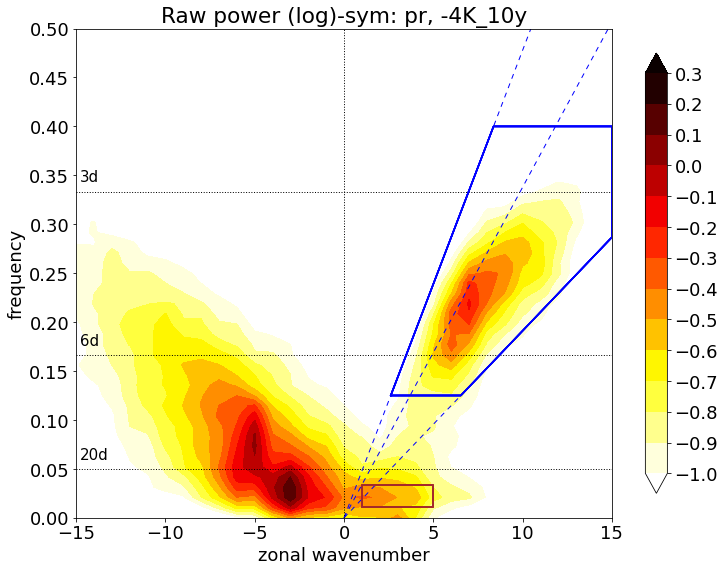

In [267]:
calc_plot_rsym = 0

if calc_plot_rsym == 1:
    # (1) Calculate and Plot precip specturm (for the sake of obataining KW amplitude, this step can be ignored.

    power_pr, r_sym, x, y, freq, zonalwnum, dof = KW.calculate_power_spectrum(pr_ano[:,:,:], 0)

    # PLotting, CHANGE ICASE & CASE_SHORT:
    clev = np.arange(-1,0.4,0.1)
    cticks = clev
    vname = 'pr'

    KW.plot_raw_sym_spectrum(power_pr, x, y, clev, cticks, figdir, vname, icase_ref, CASE_SHORT)

    # save data
    np.savez(output_dir+'pr_wavenum_freq.npz', power_pr=power_pr, r_sym=r_sym, x=x, y=y, freq=freq, zonalwnum=zonalwnum)

Critical signal strength value for significance level 0.01:  1.2796281014058064
